In [18]:
# Data Collection

!pip3 install -r '../../requirements.txt'

import kaggle
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from datetime import datetime
from PIL import Image, ImageStat
from PIL.ExifTags import TAGS
from scipy.spatial import KDTree
from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)

from sklearn import tree
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score

In [2]:
### 1. Create two folders : images, metadata.
!mkdir -p ./images
!mkdir -p ./metadata

In [3]:
## You have to collect and download a set of images. You have the following tasks to program, automating the process as much as possible:

### 1. Download open-licensed images to the folder images (minimum 100 images).
!rm -f ./images/pexels-mountain-images.zip
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nielspace/pexels-mountain-images -p ./images --unzip
print("Dataset downloaded")


100%|████████████████████████████████████████| 265M/265M [06:00<00:00, 1.02MB/s]
100%|█████████████████████████████████████████| 265M/265M [06:00<00:00, 771kB/s]
Dataset downloaded


In [6]:
def get_predominant_colors(image_file, numcolors=3, resize=150, output = []):
    # Resize image to speed up processing
    img = Image.open(image_file)
    img = img.copy()
    img.thumbnail((resize, resize))
 
    # Reduce to palette
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)
 
    # Find dominant colors
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    colors = list()
    for i in range(numcolors):
        palette_index = color_counts[i][1]
        dominant_color = palette[palette_index*3:palette_index*3+3]
        colors.append(tuple(dominant_color))
    return colors

def convert_rgb_to_names(rgb_tuple):
    
    # a dictionary of all the hex and their respective names in css3
    css3_db = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []    
    for color_hex, color_name in css3_db.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color_hex))
    kdt_db = KDTree(rgb_values)    
    distance, index = kdt_db.query(rgb_tuple)
    return {
        "index":int(index),
        "name":names[index]
    }
### 2. Save metadata of every image like image size, image format (.jpeg, .png, etc.), image orientation (landscape, portrait, square, etc.), creation date, camera model, etc. in one or more JSON files. You can make use of the Exif information present in the image files.

directory = './images/Mountain'
metadata = {}
orientation = ""
images_data =[]
data_path = "./metadata/metadata.json"

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image_data = {}
        path, file_extension = os.path.splitext(f)
        time_creation = os.path.getmtime(f)
        im = Image.open(f)
        colors = {}
        predominant_colors = get_predominant_colors(os.path.join(directory, filename))
        colors["predominant_colors"] = []
        for predominant_color in predominant_colors:
            colors["predominant_colors"].append(convert_rgb_to_names(predominant_color))
        for idx,val in enumerate(["red","green","blue"]):
            colors[val] = Image.Image.getextrema(im)[idx]
            colors[val] = colors[val] + (ImageStat.Stat(im).median[idx],)
        if im.size[0]>im.size[1] :
            orientation = "landscape"
        elif im.size[0] == im.size[1] :
            orientation = "square"
        else :
            orientation = "portrait"
        metadata[filename] = {
            "file_extension": file_extension,
            "creation_date": datetime.fromtimestamp(time_creation/1000.0).strftime("%m/%d/%Y, %H:%M:%S"),
            "size": {
                "width":im.size[0],
                "height":im.size[1]
            },
            "orientation": orientation,
            "colors": {
                "predominant_colors":{
                    "first_color":{
                        "index":colors["predominant_colors"][0]["index"],
                        "name":colors["predominant_colors"][0]["name"]
                    },
                    "second_color":{
                        "index":colors["predominant_colors"][1]["index"],
                        "name":colors["predominant_colors"][1]["name"]
                    },
                    "third_color":{
                        "index":colors["predominant_colors"][2]["index"],
                        "name":colors["predominant_colors"][2]["name"]
                    },
                },
                "red": {
                    "minimum":colors["red"][0],
                    "maximum":colors["red"][1],
                    "median":colors["red"][2]
                },
                "green": {
                    "minimum":colors["green"][0],
                    "maximum":colors["green"][1],
                    "median":colors["green"][2]
                },
                "blue": {
                    "minimum":colors["blue"][0],
                    "maximum":colors["blue"][1],
                    "median":colors["blue"][2]
                }
            }
        }
        print(metadata[filename])

with open(data_path, "w") as outfile:
    json.dump(metadata, outfile, indent=4)

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3264, 'height': 4759}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 34, 'name': 'darkslategray'}, 'second_color': {'index': 72, 'name': 'lightslategray'}, 'third_color': {'index': 120, 'name': 'silver'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 115}, 'green': {'minimum': 0, 'maximum': 255, 'median': 122}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 129}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3448, 'height': 4592}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 34, 'name': 'darkslategray'}, 'second_color': {'index': 121, 'name': 'skyblue'}, 'third_color': {'index': 66, 'name': 'lightgray'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 93}, 'green': {'minimum': 0, 'maximum': 255, 'median': 158}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 174}}}
{'file_ex

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 5472, 'height': 3648}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 39, 'name': 'dimgray'}, 'second_color': {'index': 23, 'name': 'darkgray'}, 'third_color': {'index': 120, 'name': 'silver'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 162}, 'green': {'minimum': 0, 'maximum': 252, 'median': 144}, 'blue': {'minimum': 0, 'maximum': 245, 'median': 135}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 2000, 'height': 3000}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 34, 'name': 'darkslategray'}, 'second_color': {'index': 120, 'name': 'silver'}, 'third_color': {'index': 23, 'name': 'darkgray'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 176}, 'green': {'minimum': 0, 'maximum': 255, 'median': 160}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 163}}}
{'file_extension': '.

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3648, 'height': 5472}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 90, 'name': 'mistyrose'}, 'second_color': {'index': 90, 'name': 'mistyrose'}, 'third_color': {'index': 112, 'name': 'rosybrown'}}, 'red': {'minimum': 27, 'maximum': 255, 'median': 248}, 'green': {'minimum': 29, 'maximum': 245, 'median': 212}, 'blue': {'minimum': 42, 'maximum': 245, 'median': 211}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3605, 'height': 5438}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 27, 'name': 'darkolivegreen'}, 'second_color': {'index': 58, 'name': 'lavender'}, 'third_color': {'index': 66, 'name': 'lightgray'}}, 'red': {'minimum': 11, 'maximum': 255, 'median': 170}, 'green': {'minimum': 6, 'maximum': 253, 'median': 157}, 'blue': {'minimum': 0, 'maximum': 252, 'median': 150}}}
{'file_ex

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 5472, 'height': 3648}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 39, 'name': 'dimgray'}, 'second_color': {'index': 121, 'name': 'skyblue'}, 'third_color': {'index': 109, 'name': 'powderblue'}}, 'red': {'minimum': 6, 'maximum': 255, 'median': 121}, 'green': {'minimum': 5, 'maximum': 255, 'median': 199}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 215}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3648, 'height': 5472}, 'orientation': 'portrait', 'colors': {'predominant_colors': {'first_color': {'index': 126, 'name': 'steelblue'}, 'second_color': {'index': 45, 'name': 'gainsboro'}, 'third_color': {'index': 73, 'name': 'lightsteelblue'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 148}, 'green': {'minimum': 0, 'maximum': 255, 'median': 188}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 201}}}
{'file_exten

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 3000, 'height': 1994}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 23, 'name': 'darkgray'}, 'second_color': {'index': 39, 'name': 'dimgray'}, 'third_color': {'index': 120, 'name': 'silver'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 158}, 'green': {'minimum': 12, 'maximum': 254, 'median': 163}, 'blue': {'minimum': 21, 'maximum': 223, 'median': 160}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 6000, 'height': 3376}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 78, 'name': 'maroon'}, 'second_color': {'index': 27, 'name': 'darkolivegreen'}, 'third_color': {'index': 119, 'name': 'sienna'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 93}, 'green': {'minimum': 0, 'maximum': 255, 'median': 52}, 'blue': {'minimum': 0, 'maximum': 255, 'median': 43}}}
{'file_extension': '.j

{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 6000, 'height': 4000}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 62, 'name': 'lightblue'}, 'second_color': {'index': 73, 'name': 'lightsteelblue'}, 'third_color': {'index': 72, 'name': 'lightslategray'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 166}, 'green': {'minimum': 0, 'maximum': 254, 'median': 193}, 'blue': {'minimum': 6, 'maximum': 255, 'median': 220}}}
{'file_extension': '.jpg', 'creation_date': '01/20/1970, 03:01:37', 'size': {'width': 6000, 'height': 4000}, 'orientation': 'landscape', 'colors': {'predominant_colors': {'first_color': {'index': 39, 'name': 'dimgray'}, 'second_color': {'index': 68, 'name': 'lightpink'}, 'third_color': {'index': 90, 'name': 'mistyrose'}}, 'red': {'minimum': 0, 'maximum': 255, 'median': 213}, 'green': {'minimum': 10, 'maximum': 255, 'median': 169}, 'blue': {'minimum': 12, 'maximum': 255, 'median': 175}}}
{'file

In [7]:
# Labeling and Annotation

directory = './images/Mountain'
data_path = "./metadata/metadata.json"


if os.path.isfile(data_path):
    with open(data_path) as target:
        json_data = json.load(target)
        
for filename in os.listdir(directory) :
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        tags = {}
        tags["like"] = random.randint(0,100)
        tags["hashtag"] = "moutain"
        json_data[filename]["tags"] = tags
        
with open("./metadata/metadata.json", "w") as outfile:
    json.dump(json_data, outfile, indent=4)
    
print("Annotations added")

Annotations added


In [8]:
# Data Analyses

numb_users = 1
data_path = "./metadata/metadata.json"
rand = 0

# json_data represents the metadata for each file
if os.path.isfile(data_path):
    with open(data_path) as target:
        json_data = json.load(target)
# Creating a profile for users with liked images
def create_user_profiles(json_data, directory):
    result = {}
    method_names = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            methods = [
                {
                    "name": "rand",
                    "conditions":[ 
                        {
                        "lambda":lambda input_array : random.randint(input_array[0],input_array[1]) == input_array[2],
                        "variables": [1,5,1]
                        }
                    ]
                },
                {
                    "name": "orientation",
                    "conditions":[ 
                        {
                        "lambda":lambda input_array : input_array[0] == input_array[1],
                        "variables": [json_data[filename]["orientation"],"landscape"]
                        }
                    ]
                },
                {
                    "name": "colors",
                    "conditions":[
                        {
                            "lambda":lambda input_array : input_array[0] >= input_array[1],
                            "variables": [json_data[filename]["colors"]["blue"]["median"],155]
                        }
                    ]
                }
            ]
            for method in methods:
                if method["name"] not in result.keys():
                    result[method["name"]] = []
                    method_names.append(method["name"])
                conditions_verified = True
                for condition in method["conditions"]:
                    conditions_verified = conditions_verified and condition["lambda"](condition["variables"])
                if conditions_verified:
                    result[method["name"]].append(filename)
    return (result,method_names)

profiles, method_names = create_user_profiles(json_data, directory)
print("METHOD NAMES: " + ','.join(method_names))
for profile in profiles:
    print(f"PROFILE(S):\n\t" +
    profile.upper()+":\n" +
    ','.join(profiles[profile]))

METHOD NAMES: rand,orientation,colors
PROFILE(S):
	RAND:
pexels---3182925.jpg,pexels-balamurugan-anbazhagan-763097.jpg,pexels-benjamin-suter-3733269.jpg,pexels-chris-czermak-2444429.jpg,pexels-denis-linine-714258.jpg,pexels-dev-patel-250400.jpg,pexels-eberhard-grossgasteiger-1366909.jpg,pexels-eberhard-grossgasteiger-1428277.jpg,pexels-eberhard-grossgasteiger-1612362.jpg,pexels-eberhard-grossgasteiger-1624445.jpg,pexels-eberhard-grossgasteiger-1743392.jpg,pexels-eberhard-grossgasteiger-640858.jpg,pexels-francesco-ungaro-2915997.jpg,pexels-iconcom-733174.jpg,pexels-johannes-plenio-1118861.jpg,pexels-joyston-judah-933054.jpg,pexels-luis-ruiz-991422.jpg,pexels-lukas-kloeppel-545964.jpg,pexels-marco-milanesi-2670898.jpg,pexels-mariia-kamenska-756799.jpg,pexels-markus-spiske-143577.jpg,pexels-nur-andi-ravsanjani-gusma-1208379.jpg,pexels-orest-sv-1840101.jpg,pexels-pixabay-266691.jpg,pexels-pixabay-36478.jpg,pexels-snapwire-37728.jpg,pexels-stephan-seeber-1054201.jpg,pexels-tom-verdoot-14467

RAND:

	DTC: 
		ACCURACY:	0.5882352941176471
		FEATURE IMPORTANCES: [0.13917229 0.16800861 0.04584578 0.17786169 0.17263594 0.06283035
 0.         0.06620553 0.16743981]
		F1 SCORE:	0.7083333333333334
		RECALL SCORE:	0.6296296296296297
		


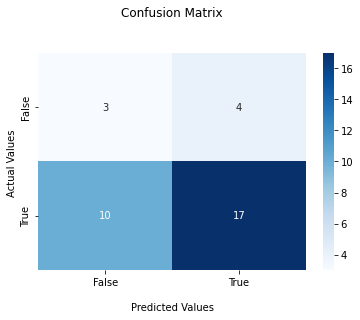


	RFC: 
		ACCURACY:	0.7352941176470589
		FEATURE IMPORTANCES: [0.14463387 0.19066449 0.08068475 0.02995106 0.14437565 0.19235162
 0.         0.05199056 0.165348  ]
		F1 SCORE:	0.8421052631578948
		RECALL SCORE:	0.8888888888888888
		


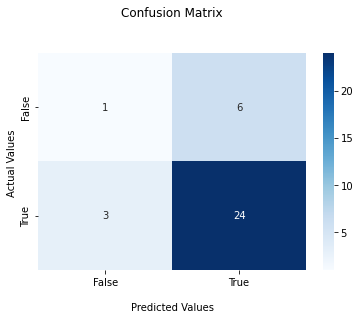

ORIENTATION:

	DTC: 
		ACCURACY:	1.0
		FEATURE IMPORTANCES: [0. 0. 0. 0. 0. 0. 1. 0. 0.]
		F1 SCORE:	1.0
		RECALL SCORE:	1.0
		


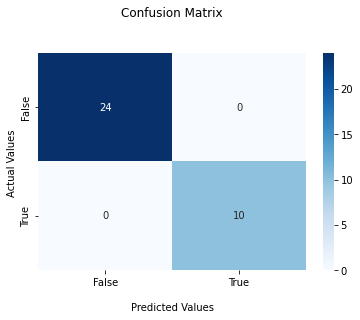


	RFC: 
		ACCURACY:	1.0
		FEATURE IMPORTANCES: [0.         0.03337922 0.01709184 0.01977594 0.00974066 0.
 0.54272664 0.20137234 0.17591335]
		F1 SCORE:	1.0
		RECALL SCORE:	1.0
		


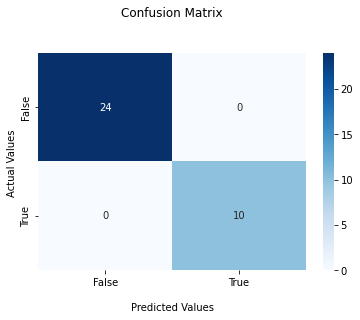

COLORS:

	DTC: 
		ACCURACY:	1.0
		FEATURE IMPORTANCES: [0. 0. 0. 0. 0. 1. 0. 0. 0.]
		F1 SCORE:	1.0
		RECALL SCORE:	1.0
		


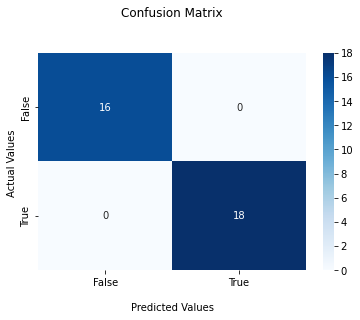


	RFC: 
		ACCURACY:	1.0
		FEATURE IMPORTANCES: [0.02672794 0.00070712 0.00699645 0.04437736 0.55085959 0.36160478
 0.         0.         0.00872675]
		F1 SCORE:	1.0
		RECALL SCORE:	1.0
		


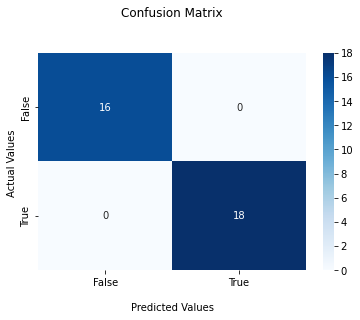

In [26]:
# Creating dataframes to predict what the user might like

def get_result_dataframe_per_profile(data, profile_user, encoder):
    result = []
    for i in data:
        if i in profile_user:
            result.append('Favorite')
        else:
            result.append('NotFavorite')
    return pd.DataFrame(encoder.fit_transform(result), columns=['Liked'])

def get_dataframe_learning(data):
    result = []
    for i in data:        
        result.append([data[i]["colors"]["predominant_colors"]["first_color"]["index"],
                  data[i]["colors"]["predominant_colors"]["second_color"]["index"],
                  data[i]["colors"]["predominant_colors"]["third_color"]["index"],
                  data[i]["colors"]["red"]["median"],
                  data[i]["colors"]["green"]["median"],
                  data[i]["colors"]["blue"]["median"],
                  data[i]["orientation"], 
                  data[i]["size"]["width"],
                  data[i]["size"]["height"]
                 ])
    return pd.DataFrame(result, columns=['First color', 'Second color', 'Third color', 'Median Red', 'Median Green', 'Median Blue','Orientation', 'Width', 'Height'])
    
def get_model(model, df, rf):
    if (model == "dtc"):
        result = tree.DecisionTreeClassifier()
        result = result.fit(df, rf.values.ravel())
    elif (model == "rfc"):
        result = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=0)
        result = result.fit(df, rf.values.ravel())
    return result

def get_dataframe_prediction(data, label_encoder):
    result = []
    for j in data :
         result.append([
             data[j]["colors"]["predominant_colors"]["first_color"]["index"],
             data[j]["colors"]["predominant_colors"]["second_color"]["index"],
             data[j]["colors"]["predominant_colors"]["third_color"]["index"],
             data[j]["colors"]["red"]["median"],
             data[j]["colors"]["green"]["median"],
             data[j]["colors"]["blue"]["median"],
             label_encoder.transform([data[j]["orientation"]])[0],
             data[j]["size"]["width"],
             data[j]["size"]["height"]
             ])
    return result

def get_prediction(method_object, label_encoder, json_data_prediction):
    prediction = method_object.predict(get_dataframe_prediction(json_data_prediction, label_encoder)) 
    return prediction
def get_stats(actual, predicted, model):
    return {
        "confusion_matrix": confusion_matrix(actual,predicted),
        "accuracy_score": accuracy_score(actual,predicted),
        "features": model.feature_importances_,
        "f1_score": f1_score(actual,predicted),
        "recall_score": recall_score(actual,predicted)
    }
def print_stats(stats):
    for method, methodValue in stats.items():
        print(f"{method.upper()}:")
        for algo, algoValue in methodValue.items():
            print(
                f"\n\t{algo.upper()}: \n\t\t"
                    f"ACCURACY:\t{algoValue['accuracy_score']}\n\t\t" 
                    f"FEATURE IMPORTANCES: {algoValue['features']}\n\t\t"
                    f"F1 SCORE:\t{algoValue['f1_score']}\n\t\t"
                    f"RECALL SCORE:\t{algoValue['recall_score']}\n\t\t"
                 )
            
            #show confusion matrix
            ax = sns.heatmap(algoValue["confusion_matrix"], annot=True, cmap='Blues')
            ax.set_title('Confusion Matrix\n\n');
            ax.set_xlabel('\nPredicted Values')
            ax.set_ylabel('Actual Values ');
            ax.xaxis.set_ticklabels(['False','True'])
            ax.yaxis.set_ticklabels(['False','True'])
            plt.show()
    
## Taking the first two thirds of our dataset to train our algorithm, and the last third to test the model
json_data_learning = dict(list(json_data.items())[:len(json_data)*2//3])
json_data_predicting = dict(list(json_data.items())[len(json_data)*2//3:])
resultframes,dtc,predictions_dtc,rfc,predictions_rfc,result_all_images, liked_encoders = [{} for _ in range(7)]
algos = ["dtc","rfc"]
models = {}
predictions = {}
stats = {}

## Creating dataframe and resultframe for learning
dataframe = get_dataframe_learning(json_data_learning)

## Generating numerical labels for column that need it
le1 = LabelEncoder()
dataframe['Orientation'] = le1.fit_transform(dataframe['Orientation'])
for method in method_names:
    if method not in stats.keys():
        stats[method] = {}
    if method not in models.keys():
        models[method] = {}
    if method not in predictions.keys():
        predictions[method] = {}
    liked_encoders[method] = LabelEncoder()
    resultframes[method]=get_result_dataframe_per_profile(json_data_learning,profiles[method],liked_encoders[method])
    # Create liked encoder for result dataframe
    for algo in algos:
        if algo not in stats[method].keys():
            stats[method][algo] = {}
        
        # Create Decision Tree Clasifier model and get predictions
        models[method][algo] = get_model(algo, dataframe.values, resultframes[method])
        predictions[method][algo] = get_prediction(models[method][algo], le1, json_data_predicting)
        result_all_images[method] = get_result_dataframe_per_profile(json_data_predicting, profiles[method],liked_encoders[method])
        stats[method][algo] = get_stats(result_all_images[method],predictions[method][algo],models[method][algo])
        clf = confusion_matrix(result_all_images[method],predictions[method][algo])
print_stats(stats)

True


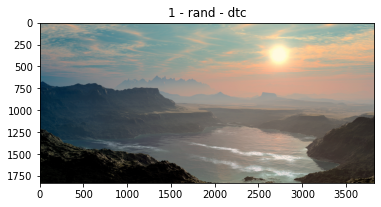

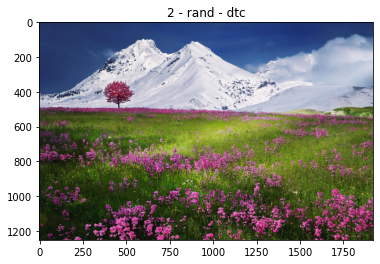

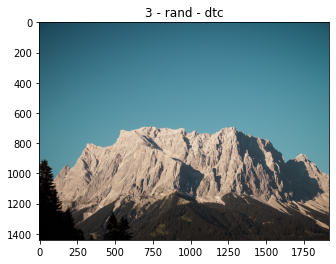

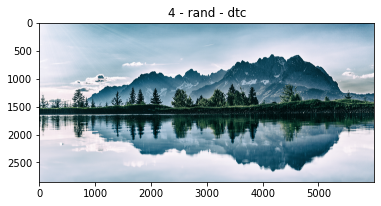

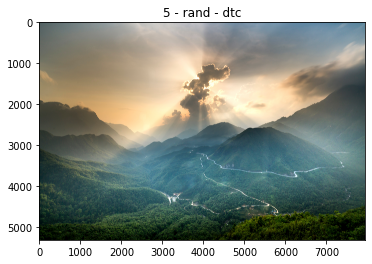

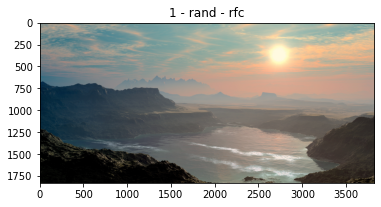

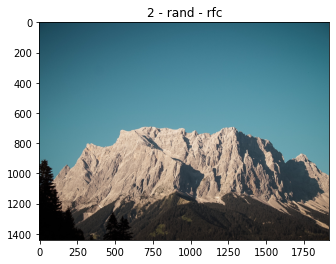

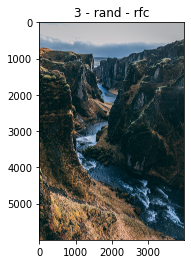

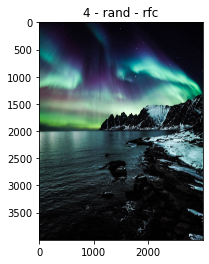

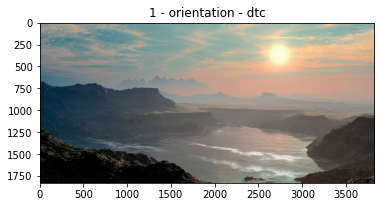

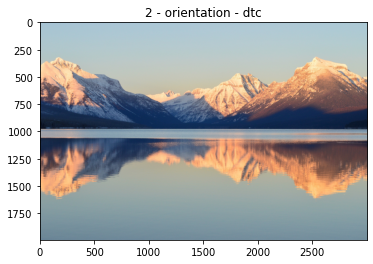

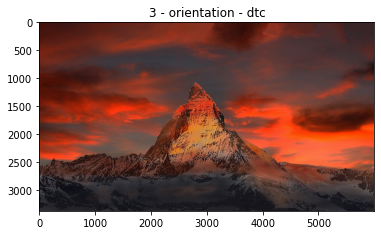

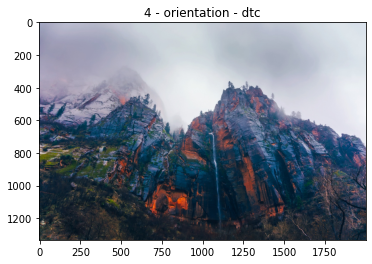

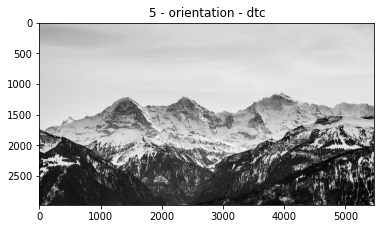

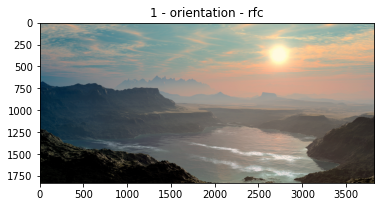

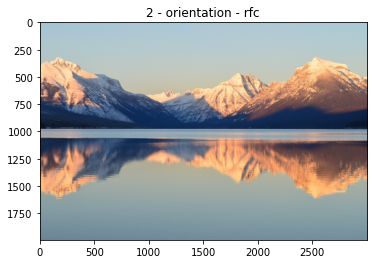

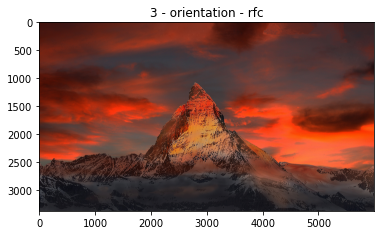

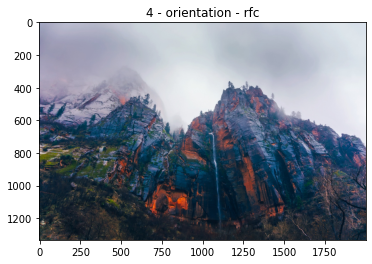

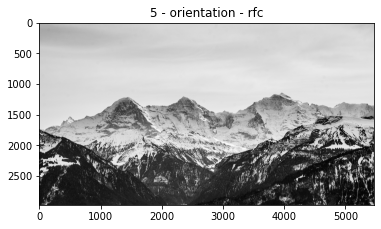

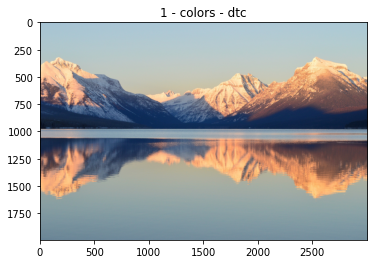

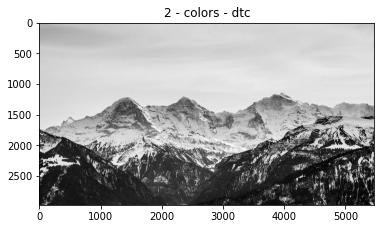

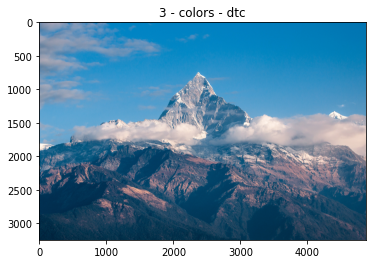

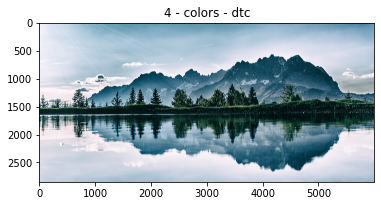

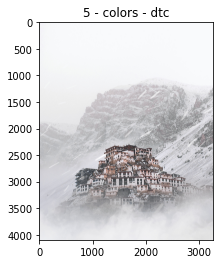

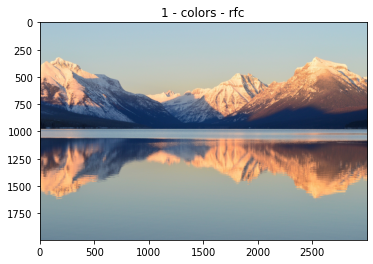

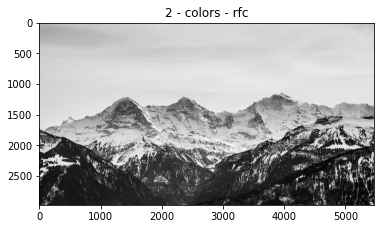

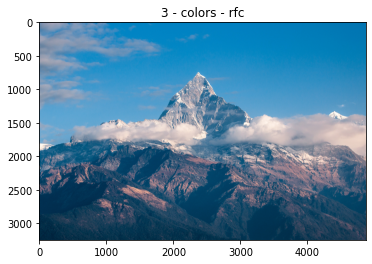

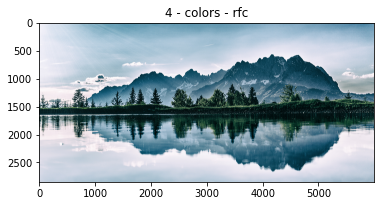

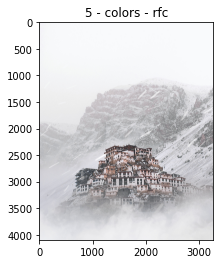

In [56]:
def print_predicted_images(json_data_list, list_indexes, nb_images_to_display = 5):
    for method, methodValue in list_indexes.items():
        for algo,algoIndexes in methodValue.items():
            i=1
            for index in algoIndexes:
                if i<=nb_images_to_display:
                    img = mpimg.imread(os.path.join(directory, json_data_list[index]))
                    imgplot = plt.imshow(img)
                    plt.title(f"{i} - {method} - {algo}")
                    plt.show()
                i+=1
        
def get_predicted_indexes(predictions, liked_encoders):
    indexes = {}
    for method, methodValue in predictions.items():
        if method not in indexes.keys():
            indexes[method] = {}
        for algo,algoValue in methodValue.items():
            indexes[method][algo] = []
            for index, prediction in enumerate(algoValue):
                if liked_encoders[method].inverse_transform([prediction])[0] == "Favorite":
                    indexes[method][algo].append(index)
    return indexes

#Print images predicted by ML algorithms
print_predicted_images(list(json_data_predicting),get_predicted_indexes(predictions,liked_encoders))